In [ ]:
-#!pip install gspread gspread-dataframe oauth2client

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default

creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
# buka file Google Sheets
sh = gc.open("Data")   # ganti sesuai nama file Google Sheets kamu

# pilih worksheet/tab bernama "(1) Data Model"
worksheet = sh.worksheet("(1) Data Model")

# baca isi worksheet ke DataFrame
import pandas as pd
from gspread_dataframe import get_as_dataframe

df = get_as_dataframe(worksheet, evaluate_formulas=True, header=0)

# cek 5 baris awal
print(df.head())

   tahun  tanggal  bulan       jam  waktu    cuaca  \
0   2025        1      1   6:33 PM  Malam    Hujan   
1   2025        6      1   6:17 PM  Malam  Mendung   
2   2025        9      2   4:10 PM   Sore  Mendung   
3   2025       21      2  10:18 AM  Siang    Hujan   
4   2025       25      2  12:55 PM  Siang    Hujan   

   jumlah burung pada titik x  titik      fase  strike  
0                   88.142857      2   Landing       1  
1                   52.666667      1   Landing       1  
2                   52.666667      1   Landing       1  
3                   95.571429      5  Take Off       1  
4                   88.142857      2   Landing       1  


In [ ]:
print("Data terakhir:", df.shape)

Data terakhir: (52859, 10)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52859 entries, 0 to 52858
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tahun                       52859 non-null  int64  
 1   tanggal                     52859 non-null  int64  
 2   bulan                       52859 non-null  int64  
 3   jam                         52859 non-null  object 
 4   waktu                       52859 non-null  object 
 5   cuaca                       52707 non-null  object 
 6   jumlah burung pada titik x  52859 non-null  float64
 7   titik                       52859 non-null  int64  
 8   fase                        52859 non-null  object 
 9   strike                      52859 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 4.0+ MB


# Pre Processing

In [ ]:
import calendar

# 1. Memperbaiki format tanggal dimana kolom 'tanggal', 'bulan' dan 'tahun' dijadikan satu

def fix_date(row):
    y, m, d = row["tahun"], row["bulan"], row["tanggal"]

    # cek jumlah hari maksimal di bulan itu
    max_day = calendar.monthrange(y, m)[1]  # contoh: Feb 2025 → 28

    # kalau tanggal lebih besar dari max_day → turunin ke max_day
    if d > max_day:
        d = max_day

    try:
        return pd.Timestamp(year=y, month=m, day=d)
    except:
        return pd.NaT

df["tanggal_fix"] = df.apply(fix_date, axis=1)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52859 entries, 0 to 52858
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tahun                       52859 non-null  int64         
 1   tanggal                     52859 non-null  int64         
 2   bulan                       52859 non-null  int64         
 3   jam                         52859 non-null  object        
 4   waktu                       52859 non-null  object        
 5   cuaca                       52707 non-null  object        
 6   jumlah burung pada titik x  52859 non-null  float64       
 7   titik                       52859 non-null  int64         
 8   fase                        52859 non-null  object        
 9   strike                      52859 non-null  int64         
 10  tanggal_fix                 52859 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)


In [ ]:
# Cek Missing Value
missing_values = df.isna().sum()
percentage_missing = (missing_values / len(df)) * 100

missing_data_summary = pd.DataFrame({
    'Jumlah Missing': missing_values,
    'Persentase Missing (%)': percentage_missing
})

print("Ringkasan Missing Values pada Dataset:")
print(missing_data_summary)

Ringkasan Missing Values pada Dataset:
                            Jumlah Missing  Persentase Missing (%)
tahun                                    0                0.000000
tanggal                                  0                0.000000
bulan                                    0                0.000000
jam                                      0                0.000000
waktu                                    0                0.000000
cuaca                                  152                0.287557
jumlah burung pada titik x               0                0.000000
titik                                    0                0.000000
fase                                     0                0.000000
strike                                   0                0.000000
tanggal_fix                              0                0.000000


- Masih terdapat missing value pada kolom 'cuaca' maka dilakukan imputasi

In [ ]:
# 2. Contoh: isi cuaca hilang dengan modus per bulan
df['cuaca'] = df.groupby('bulan')['cuaca'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Tidak Tercatat'))

In [ ]:
# Cek Missing Value
missing_values = df.isna().sum()
percentage_missing = (missing_values / len(df)) * 100

missing_data_summary = pd.DataFrame({
    'Jumlah Missing': missing_values,
    'Persentase Missing (%)': percentage_missing
})

print("Ringkasan Missing Values pada Dataset:")
print(missing_data_summary)

Ringkasan Missing Values pada Dataset:
                            Jumlah Missing  Persentase Missing (%)
tahun                                    0                     0.0
tanggal                                  0                     0.0
bulan                                    0                     0.0
jam                                      0                     0.0
waktu                                    0                     0.0
cuaca                                    0                     0.0
jumlah burung pada titik x               0                     0.0
titik                                    0                     0.0
fase                                     0                     0.0
strike                                   0                     0.0
tanggal_fix                              0                     0.0


In [ ]:
# 3. Cek jumlah baris duplikat di seluruh kolom
jumlah_duplikat = df.duplicated().sum()
print(f"Jumlah baris duplikat: {jumlah_duplikat}")

Jumlah baris duplikat: 50


- Data yang teridentifikasi sebagai duplikat tidak dieliminasi pada tahap pra-pemrosesan karena secara substansi tidak merepresentasikan pencatatan ganda. Kasus yang tampak serupa dapat berasal dari penerbangan yang berbeda (arrival maupun departure) atau dari maskapai yang berbeda yang beroperasi pada waktu dan titik yang sama. Oleh karena itu, penghapusan entri tersebut berpotensi menghilangkan informasi penting terkait variasi pergerakan pesawat dan potensi kejadian bird strike.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52859 entries, 0 to 52858
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tahun                       52859 non-null  int64         
 1   tanggal                     52859 non-null  int64         
 2   bulan                       52859 non-null  int64         
 3   jam                         52859 non-null  object        
 4   waktu                       52859 non-null  object        
 5   cuaca                       52859 non-null  object        
 6   jumlah burung pada titik x  52859 non-null  float64       
 7   titik                       52859 non-null  int64         
 8   fase                        52859 non-null  object        
 9   strike                      52859 non-null  int64         
 10  tanggal_fix                 52859 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)


# Exploratory Data Analysis (EDA)

In [ ]:
# ringkasan
print(df.info())
print(df.describe(include="all"))

# cek missing values
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52859 entries, 0 to 52858
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tahun                       52859 non-null  int64         
 1   tanggal                     52859 non-null  int64         
 2   bulan                       52859 non-null  int64         
 3   jam                         52859 non-null  object        
 4   waktu                       52859 non-null  object        
 5   cuaca                       52859 non-null  object        
 6   jumlah burung pada titik x  52859 non-null  float64       
 7   titik                       52859 non-null  int64         
 8   fase                        52859 non-null  object        
 9   strike                      52859 non-null  int64         
 10  tanggal_fix                 52859 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)


## Analisis Univariate (tiap variabel)

<Axes: title={'center': 'Distribusi Strike'}, xlabel='strike'>

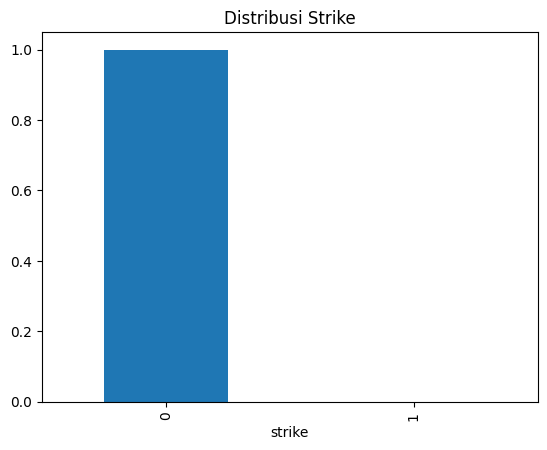

In [ ]:
# Distribusi Strike
df["strike"].value_counts(normalize=True).plot(kind="bar", title="Distribusi Strike")

<Axes: >

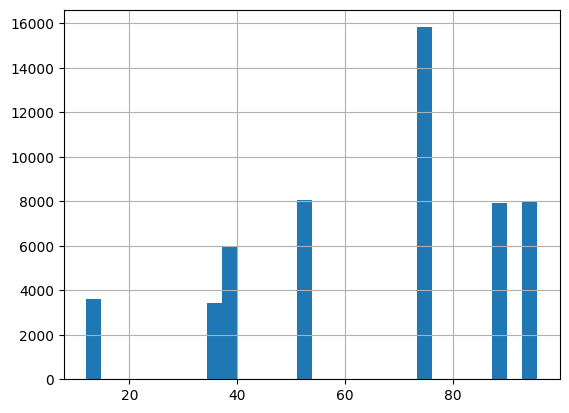

In [ ]:
# Distribusi jumlah burung
df["jumlah burung pada titik x"].hist(bins=30)

<Axes: title={'center': 'Frekuensi per Titik Lokasi'}, xlabel='titik'>

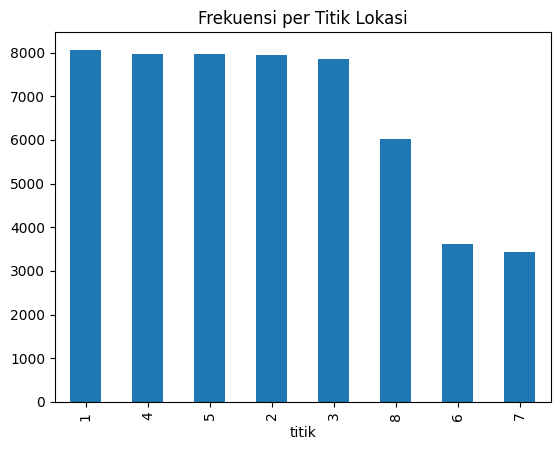

In [ ]:
# Distribusi titik lokasi
df["titik"].value_counts().plot(kind="bar", title="Frekuensi per Titik Lokasi")

<Axes: title={'center': 'Distribusi Fase Penerbangan'}, xlabel='fase'>

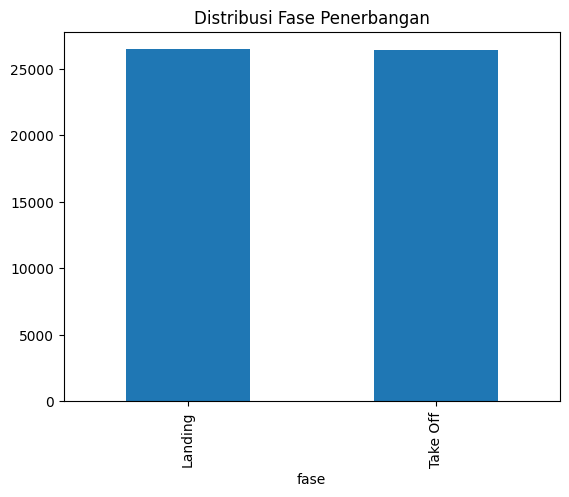

In [ ]:
# Distribusi fase penerbangan
df["fase"].value_counts().plot(kind="bar", title="Distribusi Fase Penerbangan")


## Analisis Bivariate (hubungan variabel dengan strike)

<Axes: xlabel='cuaca'>

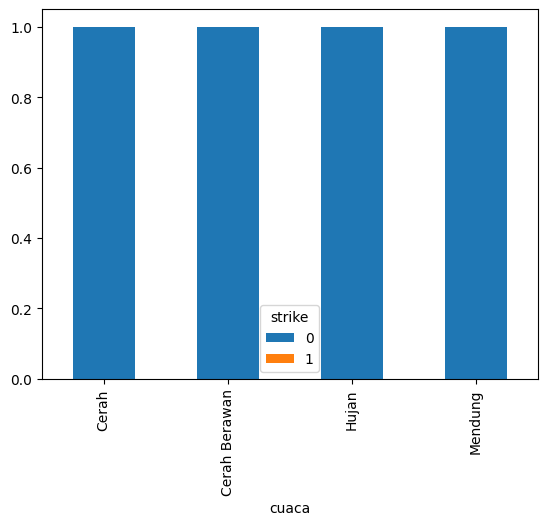

In [ ]:
# Strike vs Cuaca
pd.crosstab(df["cuaca"], df["strike"], normalize="index").plot(kind="bar", stacked=True)

In [ ]:
# Strike vs Titik
# pd.crosstab(df["titik"], df["strike"], normalize="index").plot(kind="bar", stacked=True)

<Axes: xlabel='strike', ylabel='jumlah burung pada titik x'>

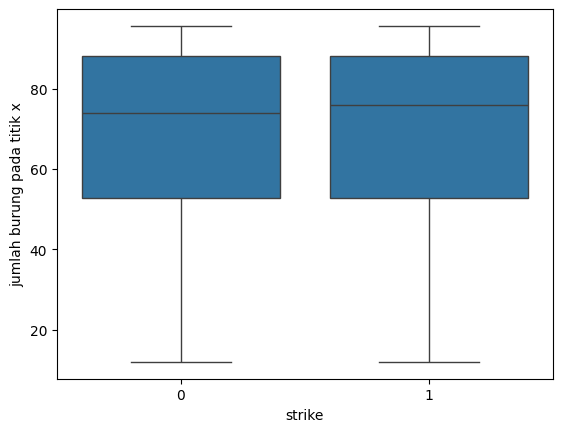

In [ ]:
# Jumlah burung vs Strike
import seaborn as sns
sns.boxplot(x="strike", y="jumlah burung pada titik x", data=df)

## Analisis Time Series

<Axes: title={'center': 'Jumlah Strike per Bulan'}, xlabel='bulan'>

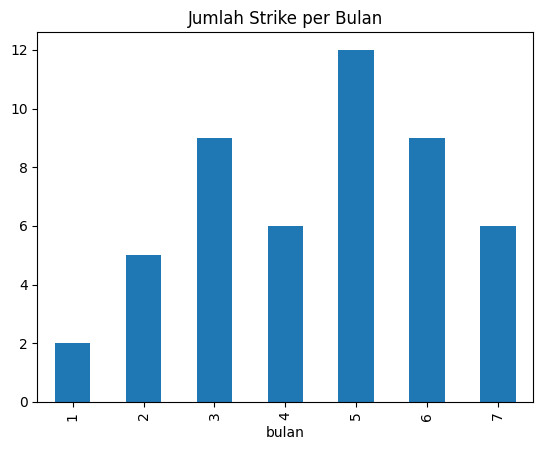

In [ ]:
df.groupby("bulan")["strike"].sum().plot(kind="bar", title="Jumlah Strike per Bulan")

<Axes: title={'center': 'Strike per Bulan'}, xlabel='tanggal_fix'>

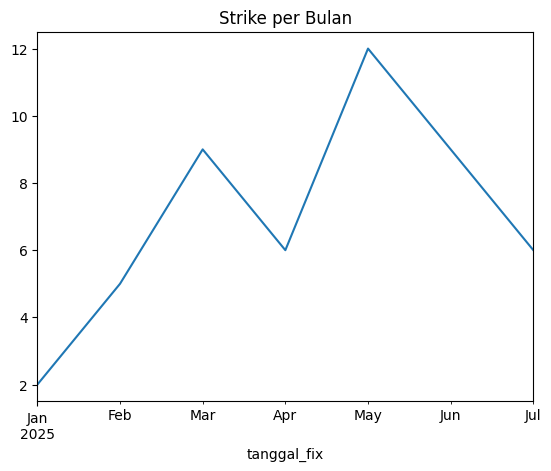

In [ ]:
df.groupby(df["tanggal_fix"].dt.to_period("M"))["strike"].sum().plot(kind="line", title="Strike per Bulan")


/tmp/ipython-input-1048436562.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["jam_int"] = pd.to_datetime(df["jam"], errors="coerce").dt.hour


<Axes: title={'center': 'Probabilitas Strike per Jam'}, xlabel='jam_int'>

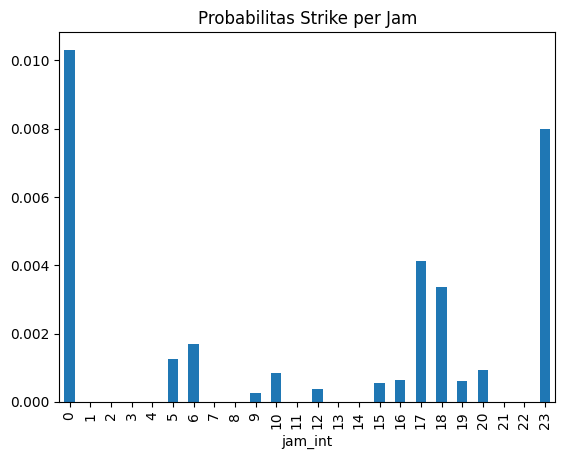

In [ ]:
df["jam_int"] = pd.to_datetime(df["jam"], errors="coerce").dt.hour
df.groupby("jam_int")["strike"].mean().plot(kind="bar", title="Probabilitas Strike per Jam")

# Menghitung peluang

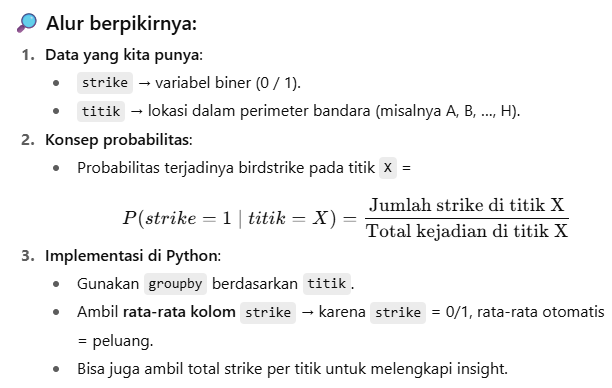

In [ ]:
# PELUANG PER TAHUN 2025 DATA JUANDA PER 22 JULI
# Probabilitas birdstrike per titik
prob_strike = df.groupby("titik")["strike"].mean()

# Jumlah strike per titik
count_strike = df.groupby("titik")["strike"].sum()

# Gabungkan jadi 1 tabel
result = pd.DataFrame({
    "Probabilitas Strike": prob_strike,
    "Jumlah Strike": count_strike,
    "Total Observasi": df.groupby("titik")["strike"].count()
}).reset_index()

print(result)

   titik  Probabilitas Strike  Jumlah Strike  Total Observasi
0      1             0.000868              7             8061
1      2             0.001261             10             7932
2      3             0.000637              5             7847
3      4             0.000753              6             7973
4      5             0.001129              9             7970
5      6             0.000828              3             3623
6      7             0.001743              6             3442
7      8             0.000499              3             6011


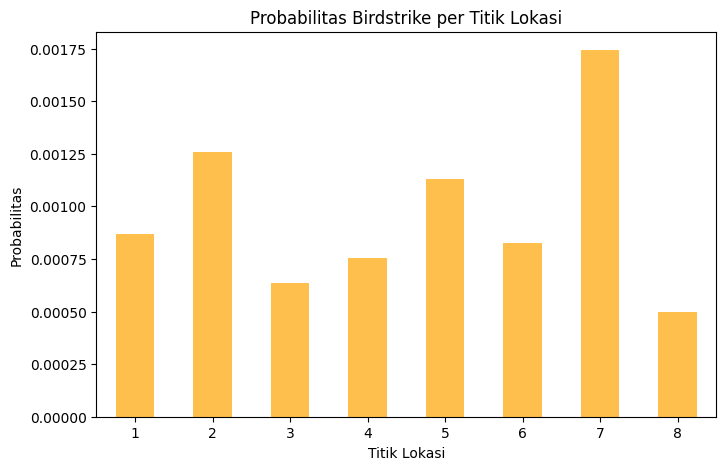

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
prob_strike.plot(kind="bar", color="orange", alpha=0.7)
plt.title("Probabilitas Birdstrike per Titik Lokasi")
plt.ylabel("Probabilitas")
plt.xlabel("Titik Lokasi")
plt.xticks(rotation=0)
plt.show()

# Prediksi Sederhana
- Batasan: phasenya selain landing/takeoff dihilangkan. Dan yang laporan hazard dihilangkan.

In [ ]:
# Mengimpor library yang diperlukan
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Fitur yang dipakai (misalnya titik, jam, cuaca, jumlah burung, fase)
X = df[["titik", "jumlah burung pada titik x", "bulan", "jam_int"]]
y = df["strike"]

# One-hot encoding untuk fitur kategorikal
X = pd.get_dummies(X, columns=["titik", "bulan"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluasi
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Probabilitas strike (bisa untuk dashboard prediksi)
y_proba = model.predict_proba(X_test)[:,1]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10564
           1       0.00      0.00      0.00         8

    accuracy                           1.00     10572
   macro avg       0.50      0.50      0.50     10572
weighted avg       1.00      1.00      1.00     10572



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


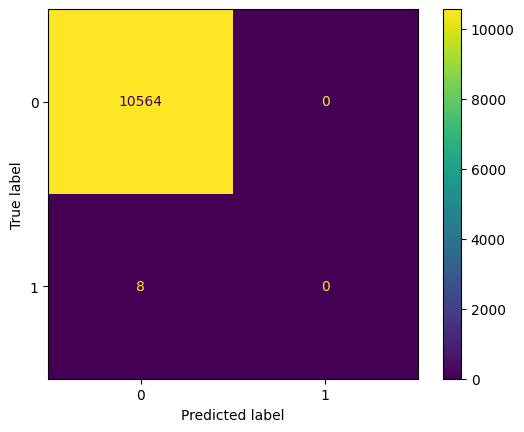

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9992432841468029


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10564
           1       0.00      0.00      0.00         8

    accuracy                           1.00     10572
   macro avg       0.50      0.50      0.50     10572
weighted avg       1.00      1.00      1.00     10572



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC-AUC: 0.526836425596365


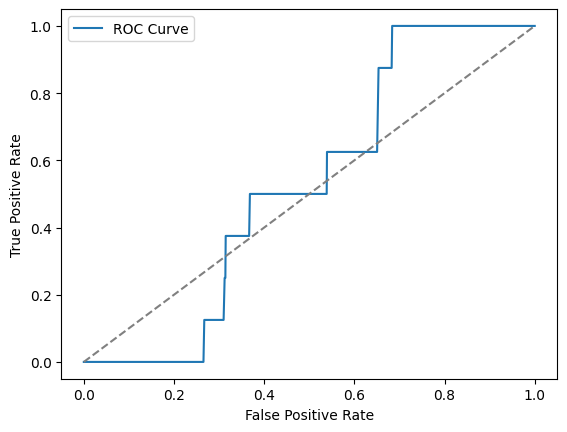

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_proba = model.predict_proba(X_test)[:,1]
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Ada Imbalance pada label data

Jumlah masing-masing kelas:
strike
0    52810
1       49
Name: count, dtype: int64

Proporsi masing-masing kelas:
strike
0    0.999073
1    0.000927
Name: proportion, dtype: float64


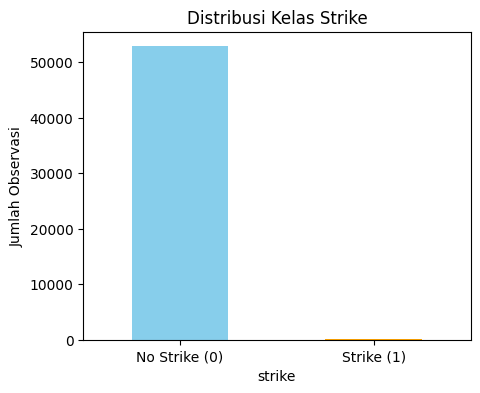

In [ ]:
import matplotlib.pyplot as plt

# Hitung distribusi kelas
strike_counts = df["strike"].value_counts()
strike_ratio = df["strike"].value_counts(normalize=True)

print("Jumlah masing-masing kelas:")
print(strike_counts)
print("\nProporsi masing-masing kelas:")
print(strike_ratio)

# Visualisasi
plt.figure(figsize=(5,4))
strike_counts.plot(kind="bar", color=["skyblue", "orange"])
plt.xticks([0,1], ["No Strike (0)", "Strike (1)"], rotation=0)
plt.title("Distribusi Kelas Strike")
plt.ylabel("Jumlah Observasi")
plt.show()

# Metode untuk mengatasi imbalance

In [ ]:
df.head()

,tahun,tanggal,bulan,jam,waktu,cuaca,jumlah burung pada titik x,titik,fase,strike,tanggal_fix,jam_int
0,2025,1,1,6:33 PM,Malam,Hujan,88.142857,2,Landing,1,2025-01-01,18
1,2025,6,1,6:17 PM,Malam,Mendung,52.666667,1,Landing,1,2025-01-06,18
2,2025,9,2,4:10 PM,Sore,Mendung,52.666667,1,Landing,1,2025-02-09,16
3,2025,21,2,10:18 AM,Siang,Hujan,95.571429,5,Take Off,1,2025-02-21,10
4,2025,25,2,12:55 PM,Siang,Hujan,88.142857,2,Landing,1,2025-02-25,12


/tmp/ipython-input-2818558839.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_model["hour"] = pd.to_datetime(df_model["jam"], errors="coerce").dt.hour


=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9990    0.9920    0.9955     10562
           1     0.0000    0.0000    0.0000        10

    accuracy                         0.9910     10572
   macro avg     0.4995    0.4960    0.4977     10572
weighted avg     0.9981    0.9910    0.9945     10572


=== Confusion Matrix ===


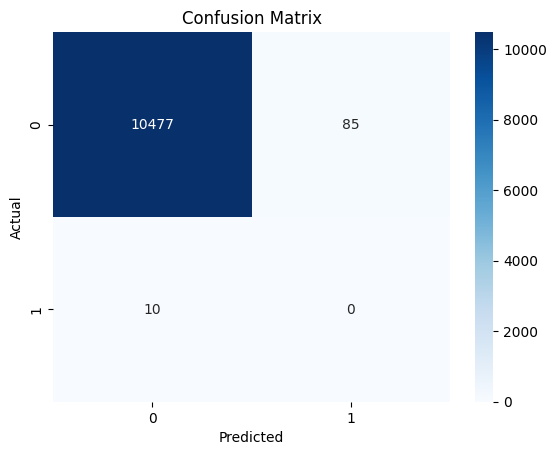

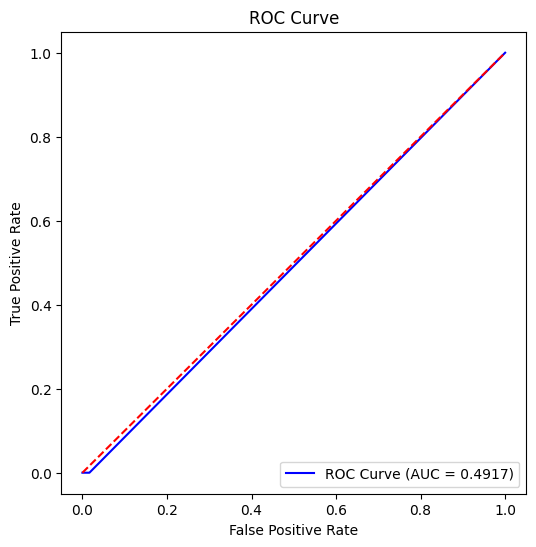

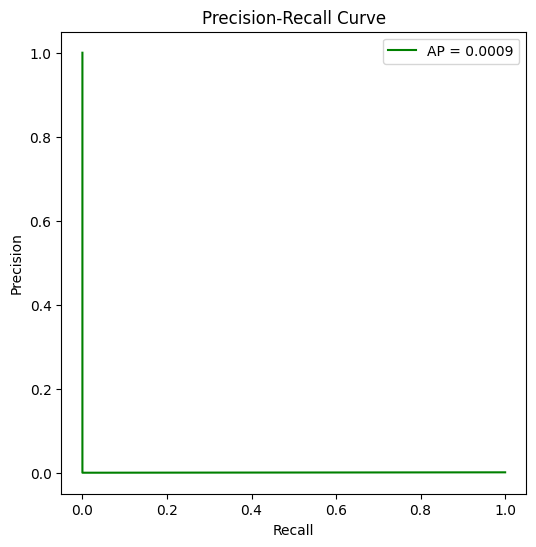

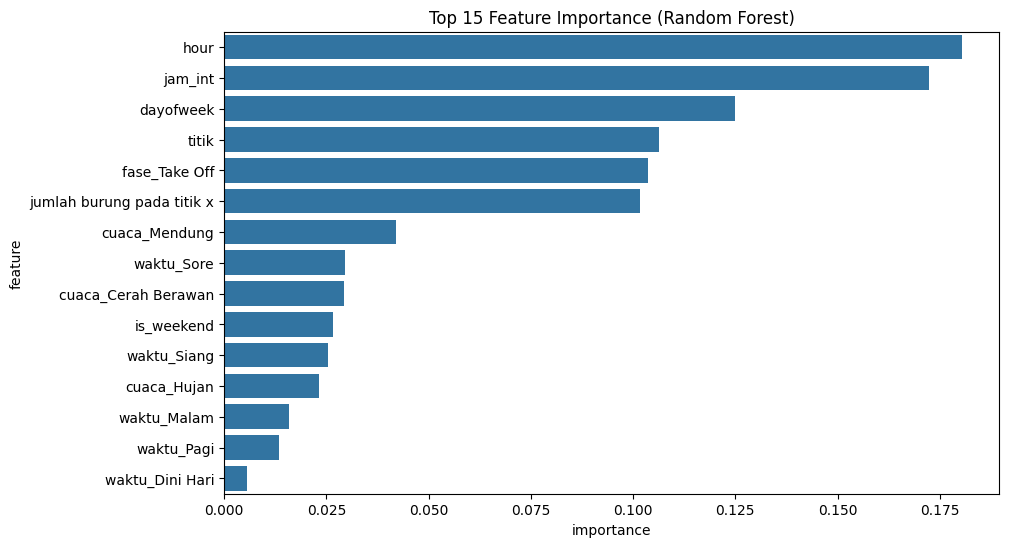

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

# --- 1. Preprocessing ---
df_model = df.copy()

# Ekstrak fitur dari datetime
df_model["dayofweek"] = df_model["tanggal_fix"].dt.dayofweek
df_model["is_weekend"] = df_model["dayofweek"].isin([5,6]).astype(int)
df_model["hour"] = pd.to_datetime(df_model["jam"], errors="coerce").dt.hour

# Drop kolom yang redundant
X = df_model.drop(columns=["strike", "tanggal_fix", "jam", "tahun", "tanggal", "bulan"])
y = df_model["strike"]

# One-hot encoding untuk kategorikal
X = pd.get_dummies(X, columns=["waktu", "cuaca", "fase"], drop_first=True)

# --- 2. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- 3. Model training ---
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)
model.fit(X_train, y_train)

# --- 4. Evaluasi dasar ---
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # probabilitas kelas 1

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# --- 5. ROC Curve & AUC ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# --- 6. Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color="green", label=f"AP = {avg_prec:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.show()

# --- 7. Feature Importance ---
importances = model.feature_importances_
feat_names = X.columns
feat_importance = pd.DataFrame({"feature": feat_names, "importance": importances})
feat_importance = feat_importance.sort_values(by="importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feat_importance.head(15))
plt.title("Top 15 Feature Importance (Random Forest)")
plt.show()

/tmp/ipython-input-2496599623.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_model["hour"] = pd.to_datetime(df_model["jam"], errors="coerce").dt.hour


Confusion Matrix:
 [[15733   110]
 [   15     0]]

Error Rate     : 0.007882
False Positive : 0.006943
False Negative : 1.000000
Accuracy       : 0.992118

              precision    recall  f1-score   support

           0   0.999047  0.993057  0.996043     15843
           1   0.000000  0.000000  0.000000        15

    accuracy                       0.992118     15858
   macro avg   0.499524  0.496528  0.498022     15858
weighted avg   0.998103  0.992118  0.995101     15858



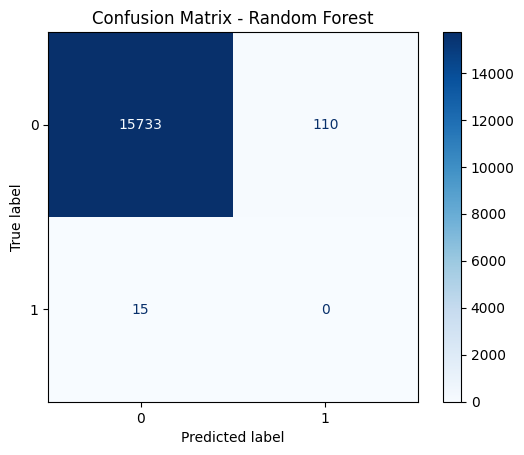

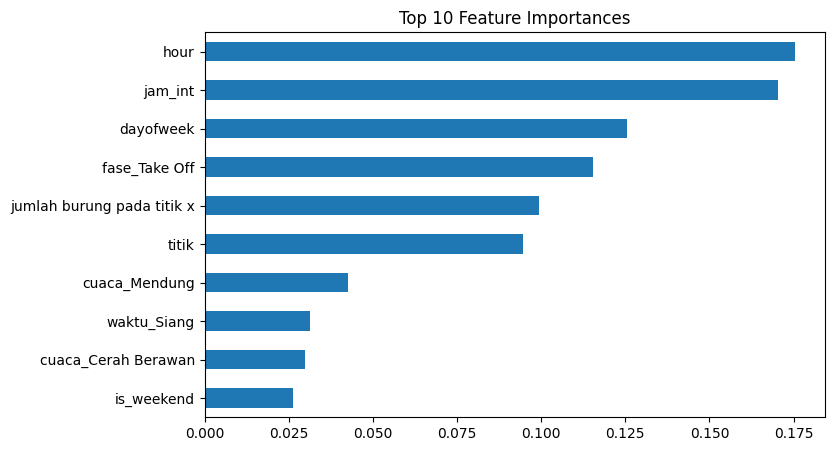

In [ ]:
# Versi ada errornya
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ========================
# 1. PREPROCESSING
# ========================
df_model = df.copy()

# Ekstrak informasi waktu
df_model["dayofweek"] = df_model["tanggal_fix"].dt.dayofweek   # 0=Senin, 6=Minggu
df_model["is_weekend"] = df_model["dayofweek"].isin([5,6]).astype(int)
df_model["hour"] = pd.to_datetime(df_model["jam"], errors="coerce").dt.hour

# Drop kolom redundant
X = df_model.drop(columns=["strike", "tanggal_fix", "jam", "tahun", "tanggal", "bulan"])
y = df_model["strike"]

# One-hot encoding
X = pd.get_dummies(X, columns=["waktu", "cuaca", "fase"], drop_first=True)

# ========================
# 2. TRAIN TEST SPLIT
# ========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# ========================
# 3. MODEL TRAINING
# ========================
model = RandomForestClassifier(
    class_weight="balanced", random_state=42, n_estimators=200
)
model.fit(X_train, y_train)

# ========================
# 4. PREDICTION
# ========================
y_pred = model.predict(X_test)

# ========================
# 5. CONFUSION MATRIX & ERROR
# ========================
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

error_rate = (FP + FN) / (TP + TN + FP + FN)
fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)

print("Confusion Matrix:\n", cm)
print(f"\nError Rate     : {error_rate:.6f}")
print(f"False Positive : {fpr:.6f}")
print(f"False Negative : {fnr:.6f}")
print(f"Accuracy       : {accuracy:.6f}\n")

# Laporan klasifikasi
print(classification_report(y_test, y_pred, digits=6))

# ========================
# 6. VISUALISASI CM
# ========================
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# ========================
# 7. FEATURE IMPORTANCE
# ========================
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind="barh", figsize=(8,5))
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# ==========================================
# 1. Import library
# ==========================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

# ==========================================
# 2. Preprocessing
# ==========================================

# Copy dataset
df_model = df.copy()

# Drop kolom yang tidak dipakai
df_model = df_model.drop(columns=["tahun", "tanggal", "bulan", "tanggal_fix"])

# Ubah jam ke numeric hour
df_model["hour"] = pd.to_datetime(df_model["jam"], errors="coerce").dt.hour
df_model = df_model.drop(columns=["jam"])

# Encode categorical
categorical_cols = ["waktu", "cuaca", "fase", "titik"]
le = LabelEncoder()
for col in categorical_cols:
    df_model[col] = le.fit_transform(df_model[col])

# Fitur & target
X = df_model.drop(columns=["strike"])
y = df_model["strike"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# SMOTE untuk imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Sebelum SMOTE:", y_train.value_counts())
print("Sesudah SMOTE:", y_train_res.value_counts())

# ==========================================
# 3. Definisi model
# ==========================================
models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    )
}

# ==========================================
# 4. Training & Evaluasi
# ==========================================
results = {}

for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    # Classification report
    print(classification_report(y_test, y_pred, digits=4))

    # ROC-AUC
    if y_prob is not None:
        auc = roc_auc_score(y_test, y_prob)
        print("ROC-AUC:", auc)
    else:
        auc = None

    # Simpan hasil
    results[name] = {
        "confusion_matrix": cm,
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "roc_auc": auc
    }

# ==========================================
# 5. Ringkasan Hasil
# ==========================================
summary = pd.DataFrame({
    model: {
        "Precision (class 1)": results[model]["classification_report"]["1"]["precision"],
        "Recall (class 1)": results[model]["classification_report"]["1"]["recall"],
        "F1-score (class 1)": results[model]["classification_report"]["1"]["f1-score"],
        "ROC-AUC": results[model]["roc_auc"]
    }
    for model in results
}).T

print("\n===== RINGKASAN HASIL =====")
print(summary)


/tmp/ipython-input-3170694938.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_model["hour"] = pd.to_datetime(df_model["jam"], errors="coerce").dt.hour


Sebelum SMOTE: strike
0    36967
1       34
Name: count, dtype: int64
Sesudah SMOTE: strike
0    36967
1    36967
Name: count, dtype: int64

===== Logistic Regression =====
Confusion Matrix:
 [[10454  5389]
 [    8     7]]
              precision    recall  f1-score   support

           0     0.9992    0.6598    0.7948     15843
           1     0.0013    0.4667    0.0026        15

    accuracy                         0.6597     15858
   macro avg     0.5003    0.5633    0.3987     15858
weighted avg     0.9983    0.6597    0.7941     15858

ROC-AUC: 0.5766984367438827

===== Decision Tree =====
Confusion Matrix:
 [[15034   809]
 [   15     0]]
              precision    recall  f1-score   support

           0     0.9990    0.9489    0.9733     15843
           1     0.0000    0.0000    0.0000        15

    accuracy                         0.9480     15858
   macro avg     0.4995    0.4745    0.4867     15858
weighted avg     0.9981    0.9480    0.9724     15858

ROC-AUC: 0.4421195

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[13904  1939]
 [   15     0]]
              precision    recall  f1-score   support

           0     0.9989    0.8776    0.9343     15843
           1     0.0000    0.0000    0.0000        15

    accuracy                         0.8768     15858
   macro avg     0.4995    0.4388    0.4672     15858
weighted avg     0.9980    0.8768    0.9335     15858

ROC-AUC: 0.6470470660018095

===== RINGKASAN HASIL =====
                     Precision (class 1)  Recall (class 1)  \
Logistic Regression             0.001297          0.466667   
Decision Tree                   0.000000          0.000000   
Random Forest                   0.000000          0.000000   
XGBoost                         0.000000          0.000000   

                     F1-score (class 1)   ROC-AUC  
Logistic Regression            0.002587  0.576698  
Decision Tree                  0.000000  0.442120  
Random Forest                  0.000000  0.469006  
XGBoost                        0.000000  0.6470

🔎 Ringkasan

- Logistic Regression
-- Recall strike (kelas 1) = 0.47 → artinya 46% birdstrike berhasil terdeteksi.
-- Precision strike = 0.0013 → banyak sekali false positive.
-- Accuracy drop ke 66% karena model jadi "over-sensitif" ke strike.
-- ROC-AUC = 0.57 (cukup buruk, tapi ada sinyal).

- Decision Tree / Random Forest
-- Recall strike = 0.0 → sama sekali tidak mendeteksi birdstrike.
-- Accuracy tinggi (94–95%) tapi model bias ke kelas mayoritas (0).
-- ROC-AUC = 0.44–0.47 (jelek).

- XGBoost
-- Recall strike = 0.0, sama → gagal deteksi strike.
-- ROC-AUC = 0.65 → agak lebih baik di probabilitas, walau cutoff default (0.5) bikin model selalu prediksi 0.

- Mencoba tuning

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Ambil probabilitas prediksi dari XGBoost (bukan kelas langsung)
xgb_model = models["XGBoost"]
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# Fungsi untuk evaluasi di berbagai threshold
def evaluate_threshold(y_true, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n===== Threshold: {threshold} =====")
    print("Confusion Matrix:\n", cm)
    print(classification_report(y_true, y_pred, digits=4))
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))

# Coba beberapa threshold
for t in [0.5, 0.3, 0.2, 0.1]:
    evaluate_threshold(y_test, y_proba, t)


===== Threshold: 0.5 =====
Confusion Matrix:
 [[13904  1939]
 [   15     0]]
              precision    recall  f1-score   support

           0     0.9989    0.8776    0.9343     15843
           1     0.0000    0.0000    0.0000        15

    accuracy                         0.8768     15858
   macro avg     0.4995    0.4388    0.4672     15858
weighted avg     0.9980    0.8768    0.9335     15858

ROC-AUC: 0.6470470660018095

===== Threshold: 0.3 =====
Confusion Matrix:
 [[13869  1974]
 [   15     0]]
              precision    recall  f1-score   support

           0     0.9989    0.8754    0.9331     15843
           1     0.0000    0.0000    0.0000        15

    accuracy                         0.8746     15858
   macro avg     0.4995    0.4377    0.4665     15858
weighted avg     0.9980    0.8746    0.9322     15858

ROC-AUC: 0.6470470660018095

===== Threshold: 0.2 =====
Confusion Matrix:
 [[13869  1974]
 [   15     0]]
              precision    recall  f1-score   support

 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

# === 1. Preprocessing Dataset ===
df_model = df.copy()

# Konversi jam jadi numerik
df_model["hour"] = pd.to_datetime(df_model["jam"], errors="coerce").dt.hour

# Drop kolom yang tidak dipakai
df_model = df_model.drop(columns=["tahun", "tanggal", "bulan", "jam", "tanggal_fix"])

# One-hot encoding untuk kolom kategorikal
df_model = pd.get_dummies(df_model, columns=["waktu", "cuaca", "fase"], drop_first=True)

# Pisahkan fitur dan target
X = df_model.drop("strike", axis=1)
y = df_model["strike"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Hitung scale_pos_weight
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

# === 2. Model XGBoost ===
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,  # handling imbalance
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_clf.fit(X_train, y_train)

# === 3. Evaluasi ===
y_pred = xgb_clf.predict(X_test)
y_prob = xgb_clf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n", classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


/tmp/ipython-input-4252755781.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_model["hour"] = pd.to_datetime(df_model["jam"], errors="coerce").dt.hour


scale_pos_weight: 1087.264705882353


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:22:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[15183   660]
 [   15     0]]

               precision    recall  f1-score   support

           0     0.9990    0.9583    0.9783     15843
           1     0.0000    0.0000    0.0000        15

    accuracy                         0.9574     15858
   macro avg     0.4995    0.4792    0.4891     15858
weighted avg     0.9981    0.9574    0.9773     15858

ROC-AUC: 0.6972206442382546


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import numpy as np

# === 1. Pilih fitur & target ===
# features = ["jam", "waktu", "cuaca", "jumlah burung pada titik x", "titik", "fase"]
target = "strike"

# X and y are already defined and preprocessed in previous cells
# X = df_model[features]
# y = df_model[target]

# === 2. Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# === 3. Preprocessing (OneHot + Passthrough numeric) ===
# The preprocessing is already done in previous steps
# categorical = ["jam", "waktu", "cuaca", "fase"]
# numeric = ["jumlah burung pada titik x", "titik"]

# preprocessor = ColumnTransformer([
#     ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
#     ("num", "passthrough", numeric)
# ])

# === 4. Pipeline with XGBoost ===
# We will use the preprocessed X_train and X_test directly with the classifier
# model = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("classifier", XGBClassifier(
#         use_label_encoder=False,
#         eval_metric="logloss",
#         scale_pos_weight= (y_train.value_counts()[0] / y_train.value_counts()[1])  # handle imbalance
#     ))
# ])

# Instantiate the XGBoost classifier directly
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight= (y_train.value_counts()[0] / y_train.value_counts()[1]),  # handle imbalance
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


# === 5. Training ===
# model.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)


# === 6. Prediksi probabilitas untuk thresholding ===
# y_prob = model.predict_proba(X_test)[:, 1]
y_prob = xgb_clf.predict_proba(X_test)[:, 1]

# === 7. Uji beberapa threshold ===
thresholds = [0.5, 0.3, 0.2, 0.1, 0.05]
for t in thresholds:
    y_pred_thr = (y_prob >= t).astype(int)
    print(f"\n===== Threshold: {t} =====")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thr))
    print(classification_report(y_test, y_pred_thr, digits=4))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:27:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



===== Threshold: 0.5 =====
Confusion Matrix:
 [[15183   660]
 [   15     0]]
              precision    recall  f1-score   support

           0     0.9990    0.9583    0.9783     15843
           1     0.0000    0.0000    0.0000        15

    accuracy                         0.9574     15858
   macro avg     0.4995    0.4792    0.4891     15858
weighted avg     0.9981    0.9574    0.9773     15858

ROC-AUC: 0.6972206442382546

===== Threshold: 0.3 =====
Confusion Matrix:
 [[15133   710]
 [   15     0]]
              precision    recall  f1-score   support

           0     0.9990    0.9552    0.9766     15843
           1     0.0000    0.0000    0.0000        15

    accuracy                         0.9543     15858
   macro avg     0.4995    0.4776    0.4883     15858
weighted avg     0.9981    0.9543    0.9757     15858

ROC-AUC: 0.6972206442382546

===== Threshold: 0.2 =====
Confusion Matrix:
 [[15005   838]
 [   14     1]]
              precision    recall  f1-score   support

 

In [ ]:
# Balanced Random Forest Classifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import numpy as np

# === 1. Pilih fitur & target ===
# features = ["jam", "waktu", "cuaca", "jumlah burung pada titik x", "titik", "fase"]
target = "strike"

# X and y are already defined and preprocessed in previous cells
# X = df_model[features]
# y = df_model[target]

# === 2. Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === 3. Preprocessing (OneHot untuk kategori, passthrough numeric) ===
# categorical = ["jam", "waktu", "cuaca", "fase"]
# numeric = ["jumlah burung pada titik x", "titik"]

# preprocessor = ColumnTransformer([
#     ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
#     ("num", "passthrough", numeric)
# ])

# === 4. Balanced Random Forest ===
# We will use the preprocessed X_train and X_test directly with the classifier
# brf = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("classifier", BalancedRandomForestClassifier(
#         n_estimators=200,
#         random_state=42,
#         n_jobs=-1
#     ))
# ])

# Instantiate BalancedRandomForestClassifier directly
brf = BalancedRandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# === 5. Training ===
# brf.fit(X_train, y_train)
brf.fit(X_train, y_train)

# === 6. Prediksi & Evaluasi ===
y_prob = brf.predict_proba(X_test)[:, 1]
y_pred = brf.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
 [[13038  2805]
 [    7     8]]
              precision    recall  f1-score   support

           0     0.9995    0.8230    0.9027     15843
           1     0.0028    0.5333    0.0057        15

    accuracy                         0.8227     15858
   macro avg     0.5012    0.6781    0.4542     15858
weighted avg     0.9985    0.8227    0.9018     15858

ROC-AUC: 0.7346651518020576


In [ ]:
# EasyEnsembleClassifier (EEC)
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# === 1. Pilih fitur & target ===
# features = ["jam", "waktu", "cuaca", "jumlah burung pada titik x", "titik", "fase"]
target = "strike"

# X and y are already defined and preprocessed in previous cells
# X = df_model[features]
# y = df_model[target]

# === 2. Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === 3. Preprocessing (kategori pakai OneHot) ===
# categorical = ["jam", "waktu", "cuaca", "fase"]
# numeric = ["jumlah burung pada titik x", "titik"]

# preprocessor = ColumnTransformer([
#     ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
#     ("num", "passthrough", numeric)
# ])

# === 4. Easy Ensemble Classifier ===
# We will use the preprocessed X_train and X_test directly with the classifier
# eec = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("classifier", EasyEnsembleClassifier(
#         n_estimators=50,   # jumlah "ensemble" (set resample)
#         random_state=42,
#         n_jobs=-1
#     ))
# ])

# Instantiate EasyEnsembleClassifier directly
eec = EasyEnsembleClassifier(
    n_estimators=50,   # jumlah "ensemble" (set resample)
    random_state=42,
    n_jobs=-1
)


# === 5. Training ===
# eec.fit(X_train, y_train)
eec.fit(X_train, y_train)

# === 6. Prediksi & Evaluasi ===
y_prob = eec.predict_proba(X_test)[:, 1]
y_pred = eec.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
 [[11310  4533]
 [    6     9]]
              precision    recall  f1-score   support

           0     0.9995    0.7139    0.8329     15843
           1     0.0020    0.6000    0.0039        15

    accuracy                         0.7138     15858
   macro avg     0.5007    0.6569    0.4184     15858
weighted avg     0.9985    0.7138    0.8321     15858

ROC-AUC: 0.7198426223989565


In [ ]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00


In [ ]:
# CatBoostClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# === 1. Pilih fitur & target ===
features = ["jumlah burung pada titik x", "titik", "hour", "dayofweek", "is_weekend", "waktu_Dini Hari", "waktu_Malam", "waktu_Pagi", "waktu_Siang", "waktu_Sore", "cuaca_Cerah Berawan", "cuaca_Hujan", "cuaca_Mendung", "fase_Take Off"]
target = "strike"

# Use the already processed X and y
# X = df_model[features]
# y = df_model[target]

# === 2. Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === 3. Identifikasi kolom kategori ===
# Since we used one-hot encoding, there are no categorical features in X_train
# If you want to use CatBoost's internal categorical handling, you would need to adjust preprocessing.
# For now, we will treat all features as numerical as they are already one-hot encoded or numerical.
cat_features = [] # Assuming X is already preprocessed with one-hot encoding

# === 4. Hitung scale_pos_weight ===
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

# === 5. Definisikan CatBoost ===
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    eval_metric="AUC",
    random_seed=42,
    verbose=200,
    # cat_features=cat_features, # Remove this if treating all as numerical after one-hot
    scale_pos_weight=scale_pos_weight
)

# === 6. Training ===
# Create CatBoost Pool if using internal categorical handling, otherwise fit directly
# train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
# test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

# cat_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100)


# === 7. Prediksi & Evaluasi ===
y_prob = cat_model.predict_proba(X_test)[:, 1]
y_pred = cat_model.predict(X_test)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

scale_pos_weight: 1087.264705882353
0:	test: 0.7202487	best: 0.7202487 (0)	total: 60.9ms	remaining: 1m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7360327379
bestIteration = 1

Shrink model to first 2 iterations.

Confusion Matrix:
 [[11463  4380]
 [    6     9]]
              precision    recall  f1-score   support

           0     0.9995    0.7235    0.8394     15843
           1     0.0021    0.6000    0.0041        15

    accuracy                         0.7234     15858
   macro avg     0.5008    0.6618    0.4217     15858
weighted avg     0.9985    0.7234    0.8386     15858

ROC-AUC: 0.7360327379073829


In [ ]:
# CatBoostClassifier with treshold tuning
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# ambil probabilitas kelas 1 dari CatBoost
y_prob = cat_model.predict_proba(X_test)[:, 1]

# coba beberapa threshold
thresholds = [0.5, 0.3, 0.2, 0.1]

for thr in thresholds:
    print(f"\n===== Threshold: {thr} =====")
    y_pred_thr = (y_prob >= thr).astype(int)

    cm = confusion_matrix(y_test, y_pred_thr)
    print("Confusion Matrix:\n", cm)

    print(classification_report(y_test, y_pred_thr, digits=4))

    roc_auc = roc_auc_score(y_test, y_prob)
    print("ROC-AUC:", roc_auc)


===== Threshold: 0.5 =====
Confusion Matrix:
 [[11463  4380]
 [    6     9]]
              precision    recall  f1-score   support

           0     0.9995    0.7235    0.8394     15843
           1     0.0021    0.6000    0.0041        15

    accuracy                         0.7234     15858
   macro avg     0.5008    0.6618    0.4217     15858
weighted avg     0.9985    0.7234    0.8386     15858

ROC-AUC: 0.7360327379073829

===== Threshold: 0.3 =====
Confusion Matrix:
 [[    0 15843]
 [    0    15]]
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     15843
           1     0.0009    1.0000    0.0019        15

    accuracy                         0.0009     15858
   macro avg     0.0005    0.5000    0.0009     15858
weighted avg     0.0000    0.0009    0.0000     15858

ROC-AUC: 0.7360327379073829

===== Threshold: 0.2 =====
Confusion Matrix:
 [[    0 15843]
 [    0    15]]
              precision    recall  f1-score   support

 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [ ]:
# EasyEnsembleClassifier (boosting khusus imbalance) & CatBoostClassifier (stabil di data imbalance)
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import EasyEnsembleClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Model base
easy = EasyEnsembleClassifier(
    n_estimators=10,
    random_state=42
)

cat = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,  # pakai imbalance ratio
    verbose=0,
    random_state=42
)

# Meta-model (level-2)
meta = LogisticRegression(max_iter=1000, class_weight="balanced")

# Stacking Ensemble
stack_model = StackingClassifier(
    estimators=[('easy', easy), ('cat', cat)],
    final_estimator=meta,
    cv=5,
    n_jobs=-1,
    passthrough=True  # biar meta-model juga dapat input fitur asli
)

# Training
stack_model.fit(X_train, y_train)

# Evaluasi
y_pred = stack_model.predict(X_test)
y_prob = stack_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# Makin jelek jangan dipake


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
 [[10351  5492]
 [    5    10]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9995    0.6533    0.7902     15843
           1     0.0018    0.6667    0.0036        15

    accuracy                         0.6534     15858
   macro avg     0.5007    0.6600    0.3969     15858
weighted avg     0.9986    0.6534    0.7894     15858

ROC-AUC: 0.6745208188684803


In [ ]:
# Ternyata yang paling oke yaitu CatBoost
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# ======================
# 1. Train CatBoost
# ======================
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric="AUC",
    scale_pos_weight=scale_pos_weight,  # dari imbalance ratio
    random_seed=42,
    verbose=100,
    early_stopping_rounds=100
)

cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

# ======================
# 2. Kalibrasi probabilitas
# ======================
calibrated_model = CalibratedClassifierCV(base_estimator=cat_model, method="sigmoid", cv="prefit")
calibrated_model.fit(X_train, y_train)

# ======================
# 3. Evaluasi
# ======================
y_prob = calibrated_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# cek contoh probabilitas prediksi
print("\nContoh probabilitas prediksi (persentase risiko birdstrike):")
for i in range(5):
    print(f"Sample {i+1}: {y_prob[i]*100:.2f}%")

ModuleNotFoundError: No module named 'catboost'

In [ ]:
%pip install catboost

In [ ]:
import pandas as pd
from catboost import CatBoostClassifier # Import CatBoostClassifier
from sklearn.model_selection import train_test_split
import numpy as np


# Recreate df_model and X with necessary preprocessing steps
df_model = df.copy() # Assuming df is available from previous cells

# Konversi jam jadi numerik
df_model["hour"] = pd.to_datetime(df_model["jam"], errors="coerce").dt.hour

# Drop kolom yang tidak dipakai
df_model = df_model.drop(columns=["tahun", "tanggal", "bulan", "jam", "tanggal_fix"])

# One-hot encoding untuk kolom kategorikal
df_model = pd.get_dummies(df_model, columns=["waktu", "cuaca", "fase"], drop_first=True)

# Pisahkan fitur dan target
X = df_model.drop("strike", axis=1)
y = df_model["strike"]

# Split data to get scale_pos_weight from training set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Hitung scale_pos_weight from the training data
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos

# Train CatBoost model
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric="AUC",
    random_seed=42,
    verbose=0,  # Set verbose to 0 to reduce output during training
    early_stopping_rounds=100,
    scale_pos_weight=scale_pos_weight
)

# Fit the model
cat_model.fit(X_train, y_train)


# Use the trained cat_model for prediction
y_prob = cat_model.predict_proba(X)[:, 1]  # get probability of class 1 (birdstrike)

# add to dataframe
df_model["prob_birdstrike"] = y_prob

# display some example rows
# Use original column names for display (need to map back or use original df)
# Assuming original df columns 'titik', 'waktu', 'cuaca', 'fase' are still desired for display

# To display original values, we can merge or use the original df
# Let's use the original df for display columns and merge with the prediction
df_display = df[['titik', 'waktu', 'cuaca', 'fase']].copy()
df_display['prob_birdstrike'] = y_prob # Assuming y_prob is in the same order as original df

print(df_display.head(10))

/tmp/ipython-input-2655748113.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_model["hour"] = pd.to_datetime(df_model["jam"], errors="coerce").dt.hour


   titik  waktu          cuaca      fase  prob_birdstrike
0      2  Malam          Hujan   Landing         0.000112
1      1  Malam        Mendung   Landing         0.935368
2      1   Sore        Mendung   Landing         0.935548
3      5  Siang          Hujan  Take Off         0.000134
4      2  Siang          Hujan   Landing         0.000721
5      3   Pagi        Mendung   Landing         0.951240
6      1  Malam        Mendung   Landing         0.935490
7      4   Sore  Cerah Berawan   Landing         0.001484
8      2  Siang  Cerah Berawan   Landing         0.996736
9      5  Siang          Hujan   Landing         0.919949
